In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
import pandas as pd
import PIL
import numpy as np 
import matplotlib.pyplot as plt
from easyimages import EasyImageList
from torch import nn
import torch
from sklearn.metrics import accuracy_score, classification_report, log_loss
from pretrainedmodels.models import resnet18, resnet50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# For details related to dataloading check the previous notebook (pytorch-fmnist)

In [5]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

class FashionMnist(Dataset):

    def __len__(self):
        return len(self.metadata_df)

    def __init__(self, metadata_df,
                 transform=None):
        
        self.metadata_df = metadata_df.copy()
        self.transform = transform
    
    def load_image_and_target(self,index):
        # .iloc is short for integer loc it returns a row of data based on its ored not index-value(if not the same)
        oneimage = self.metadata_df.iloc[index]
        image, y = PIL.Image.fromarray(
            np.array(oneimage[1:]).reshape(28, 28).astype('uint8'), 'L').convert('RGB'), oneimage[0]
        return image, y
        
    def __getitem__(self, index):
        X, y = self.load_image_and_target(index)
        # We can transform the output images here, cast to torch data-format and/or do augmentations
        X = self.transform(X)
            
        return X, y

    def collate_func(self, batch):
        pass



###  Understanding AdaptiveAveragePooling

In a moment you will see that we change one of the pretrained models by swaping  the AveragePool operation for AdaptiveAveragePooling.

The ideas is that adaptive pooling always returns our desired shape. This is useful if you want your NN to support different images shapes


In [6]:
tensor = torch.randn((1, 128, 8, 8))

print(nn.AdaptiveAvgPool2d((1, 1))(tensor).shape)
print(nn.AvgPool2d((3,3))(tensor).shape)


torch.Size([1, 128, 1, 1])
torch.Size([1, 128, 2, 2])


### Adapting a pretrained model to be used for different number of classes
By default many of the pretrained models require a input image of a given shape (usually 224x224x3) This is not our case so we need to chaged that, one way to do it is to change the network architecture of the model as described in Adaptive Pooling Step

In [7]:
N_CLASSES = 10

def freeze_model(model):
    model.eval()
    for params in model.parameters():
        params.requires_grad = False
        
cnn = resnet18(pretrained='imagenet')
# freeze_model(cnn)
cnn.avgpool = nn.AdaptiveAvgPool2d(1) # This will allow to use different input sizes
cnn.last_linear = nn.Sequential(nn.Linear(cnn.last_linear.in_features, 1024), 
                                nn.Linear(1024, 10))

from torchsummary import torchsummary

torchsummary.summary(cnn.cuda(), input_size=(3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### Define your loss function / crieterion, optimizers and Data

In [8]:
LR= 0.005
BATCH_SIZE = 8
DATASET_USAGE_SIZE = 0.15
N_CLASSES = 10

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

OPTIMIZER = 'SGD' # one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

cnn.to(DEVICE)

# Create dataset loaders
    
PATH_TO_FMNIST_TRAIN = './data/fashion-mnist_train.csv'
PATH_TO_FMNIST_TEST = './data/fashion-mnist_test.csv'


dftrain = pd.read_csv(PATH_TO_FMNIST_TRAIN).sample(frac=DATASET_USAGE_SIZE)
dftest = pd.read_csv(PATH_TO_FMNIST_TEST).sample(frac=0.1)

transform_train = transforms.Compose([transforms.Resize(34), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=MEAN, std=STD)
                                     ]
                                    )
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.Resize(34), 
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=MEAN, std=STD)
                                    ])
fmnist_test = FashionMnist(dftest, transform=transform_test)

fmnist_train_dl = DataLoader(fmnist_train, batch_size=BATCH_SIZE)
fmnist_test_dl = DataLoader(fmnist_test, batch_size=BATCH_SIZE)

# Lets try to use the criterion with dummy data
yp = torch.randn(BATCH_SIZE, 10)
yt = torch.randint(10, (BATCH_SIZE,))
criterion(yp, yt.long())


tensor(2.5282)

In [9]:
def evaluate_model(model, test_loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in test_loader:
            X, y = batch
#             X = X.repeat(1, 3, 1, 1)
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            pred = cnn(X)
            collect_results.append(pred.sigmoid().detach().cpu().numpy())
            collect_target.append(y) 
        
    preds_proba = np.concatenate(collect_results)
    preds = preds_proba.argmax(axis=1)
    targets = np.concatenate(collect_target)

    ll = log_loss(targets, preds_proba)
    acc = accuracy_score(targets, preds)
    if print_info:
        print("test log-loss: {}".format(ll))
        print("overall accuracy:  {}".format(ac))
#         print(classification_report(targets, preds))
    model.train()
#         freeze_model(model)
        
    return ll, acc
            
collect = []
for epoch in range(50):
    lossacc = 0
    for i, batch in enumerate(fmnist_train_dl):
        optimizer.zero_grad()
        X, y = batch
#         X = X.repeat(1, 3, 1, 1)
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_pred = cnn(X)
        
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()  
        collect.append(float(loss.detach().cpu().numpy()))  
        
    lltest, acctest = evaluate_model(cnn, fmnist_test_dl)
    lltrain, acctrain = evaluate_model(cnn, fmnist_train_dl)
    print("test: loss: {}  acc: {}".format(lltest, acctest))
    print("train: loss: {}  acc: {}".format(lltrain, acctrain))
    

test: loss: 1.4739263507127762  acc: 0.862
train: loss: 1.469683728562461  acc: 0.8712222222222222
test: loss: 1.4466450746059418  acc: 0.867
train: loss: 1.4374936942524381  acc: 0.8966666666666666
test: loss: 1.4236784858703613  acc: 0.892
train: loss: 1.4104776178995768  acc: 0.9188888888888889
test: loss: 1.4379491866827012  acc: 0.864
train: loss: 1.4206103569401636  acc: 0.9097777777777778


KeyboardInterrupt: 

# Exercises

- What do you think of the results?
- Try training the model without freezing. What do you observe?
- Visualize the results

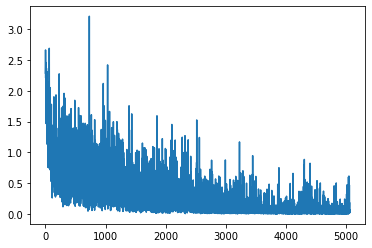

In [10]:
%matplotlib inline
plt.plot(collect[:])